# Basic CNN for traffic sign recognition
## Christian Igel, 2022

This notebook provides a template for a small CNN for the German Traffic Sign Recognition Benchmark. The data is described in:

Johannes Stallkamp, Marc Schlipsing, Jan Salmen, and Christian Igel. Man vs. Computer: Benchmarking Machine Learning Algorithms for Traffic Sign Recognition. *Neural Networks* **32**, pp. 323-332, 2012

This notebook is a template, without modification the model does not even come close to the state-of-the-art. 

Please [contact me](mailto:igel@diku.dk) if you have suggestions for improving the notebook.

Do the imports first:

In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np

import torch 
import torch.optim as optim

import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms
from torch.utils.data.dataset import Dataset
from torchvision.datasets.utils import download_url, extract_archive

Check if a GPU is available:

In [2]:
gpu = torch.cuda.is_available()
device = torch.device("cuda:0" if gpu else "cpu")
print("device:", device)

device: cuda:0


The GTSRB data wrapped in a `Dataset`. This is implemented in the file `GTSRBTrafficSigns.py`. Let's import the class:

In [4]:
from GTSRBTrafficSigns import GTSRBTrafficSigns

In [5]:
dataset_train = GTSRBTrafficSigns()

Using existing ./GTSRB/train


Define the data loader for training:

In [6]:
batch_size = 128
generator_train = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True, num_workers=4)

In [7]:
print("Number of training patterns:", len(dataset_train))

Number of training patterns: 39209


Let's visualize some input images. This visualization is very important, among others to verify that the data augmentation works as expected.

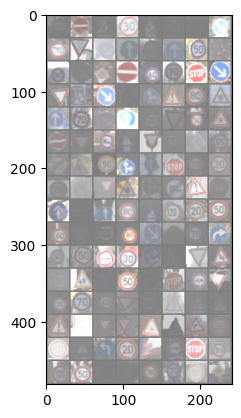

In [8]:
# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(generator_train)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))

Let's look at each image in the batch with its label:

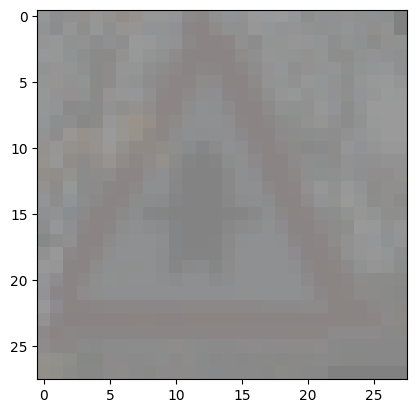

11 




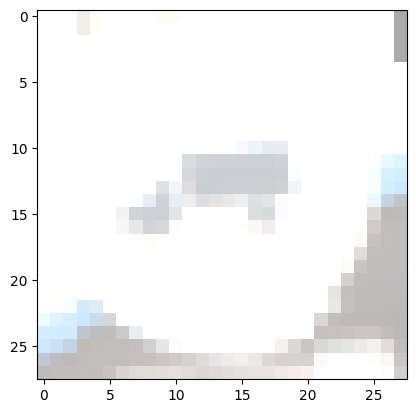

16 




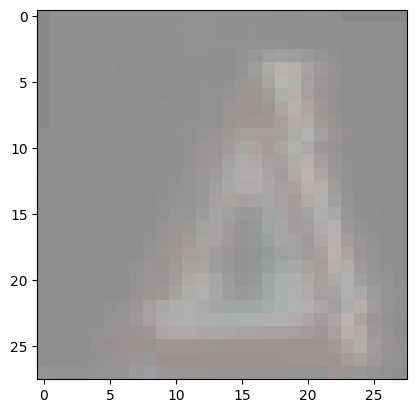

11 




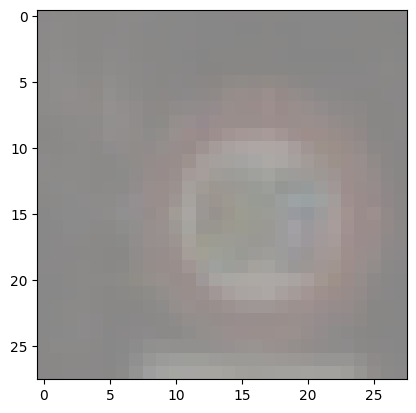

5 




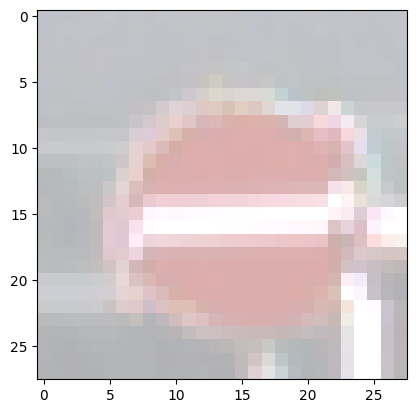

17 




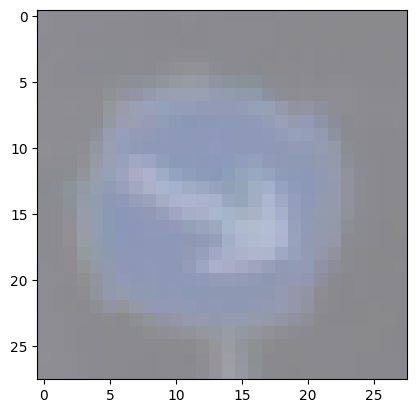

38 




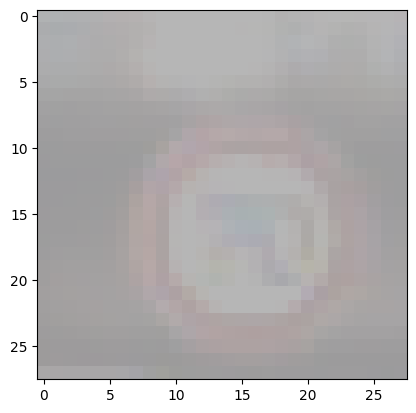

4 




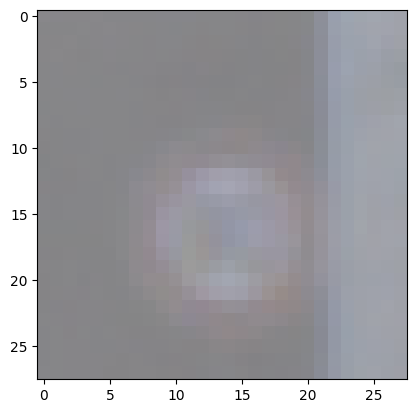

5 




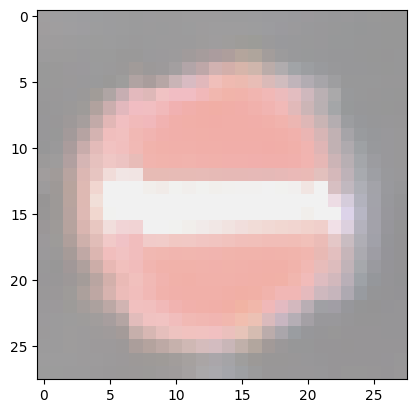

17 




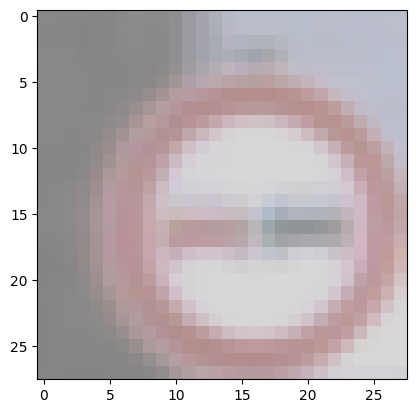

9 




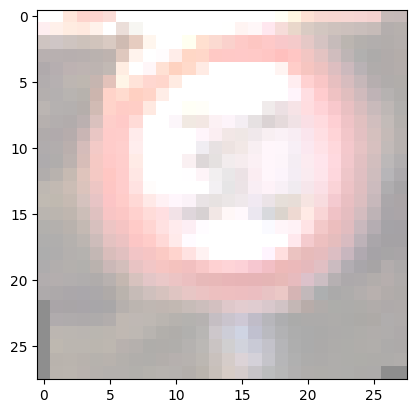

1 




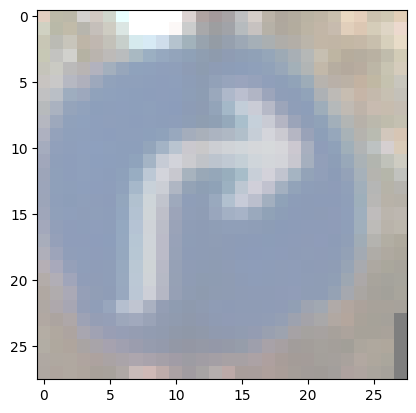

33 




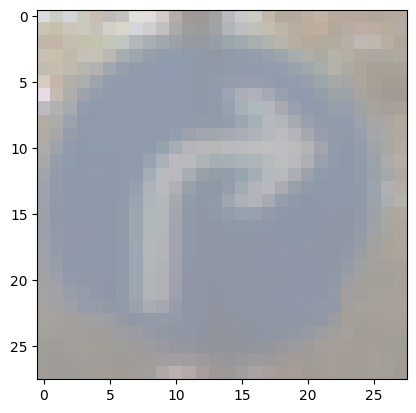

33 




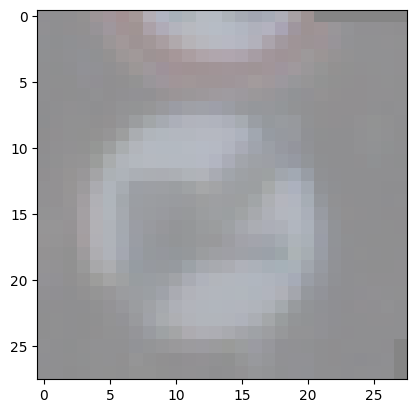

42 




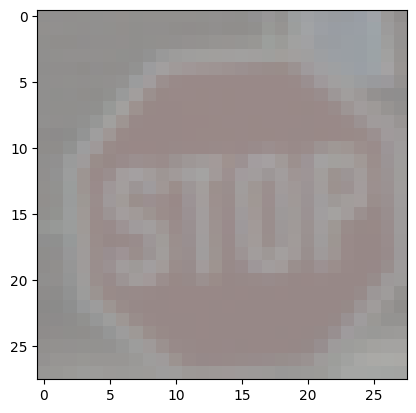

14 




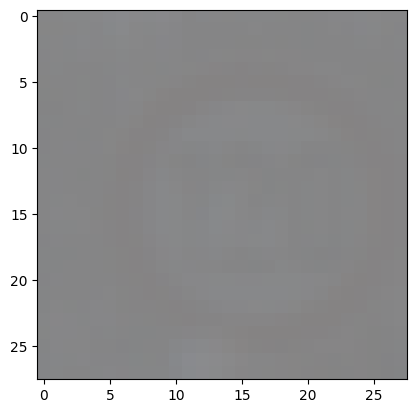

8 




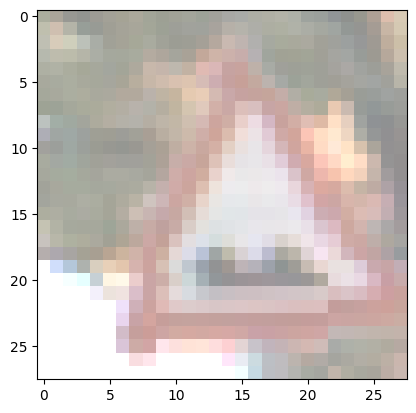

22 




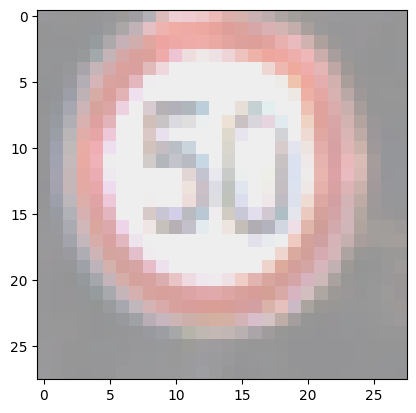

2 




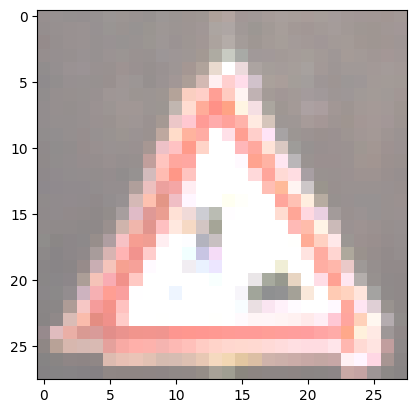

25 




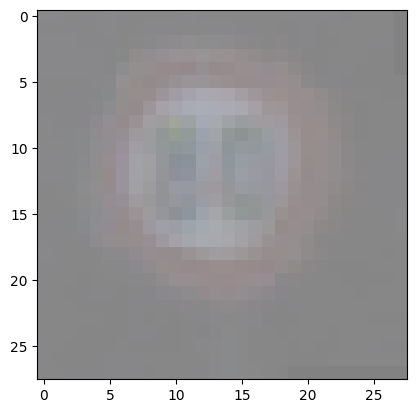

5 




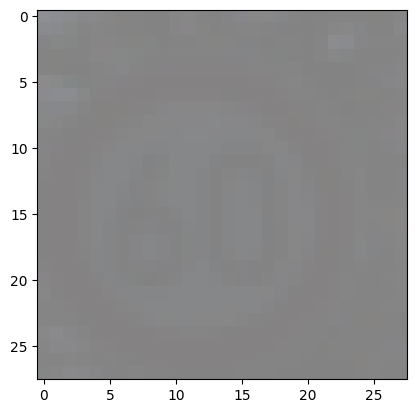

3 




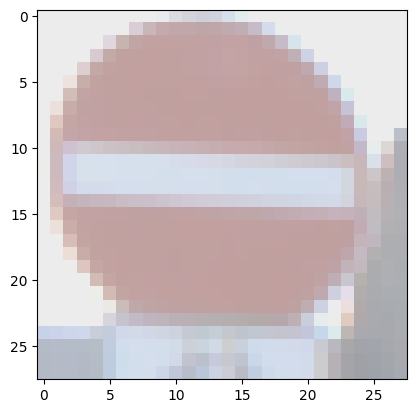

17 




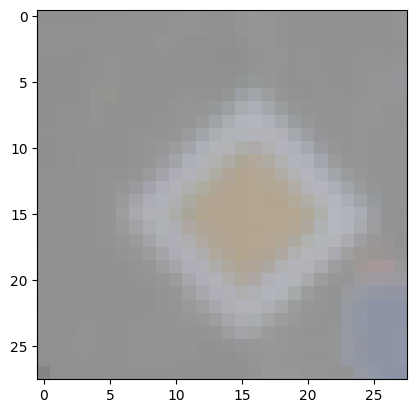

12 




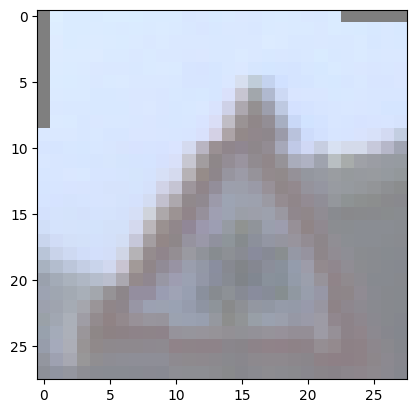

30 




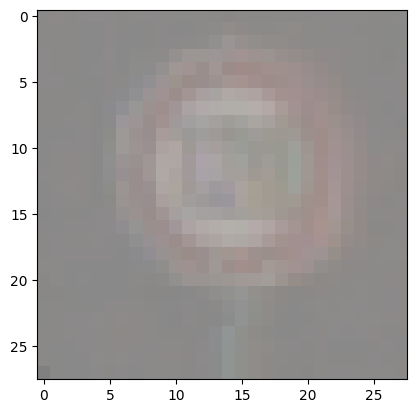

8 




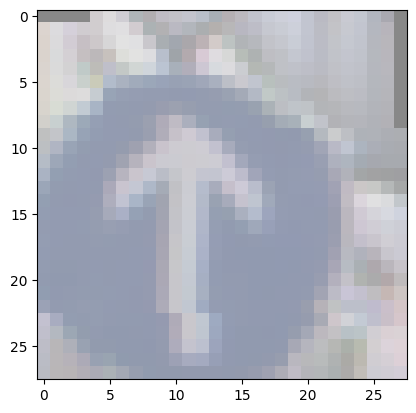

35 




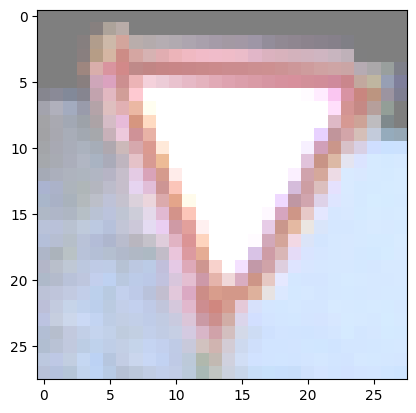

13 




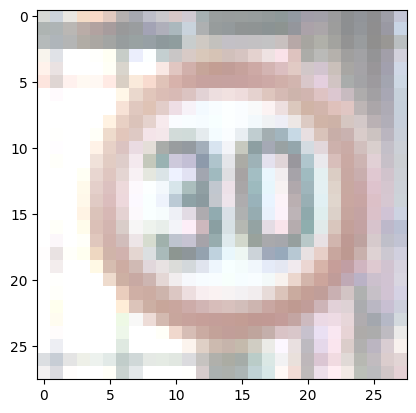

1 




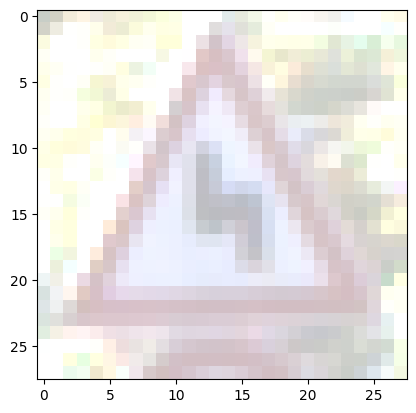

21 




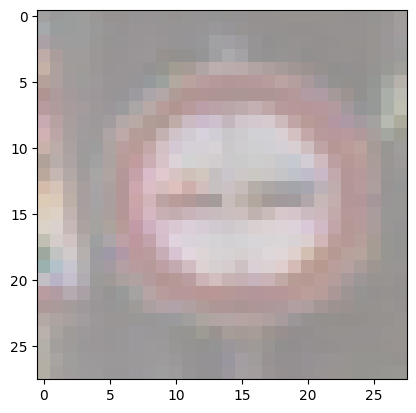

9 




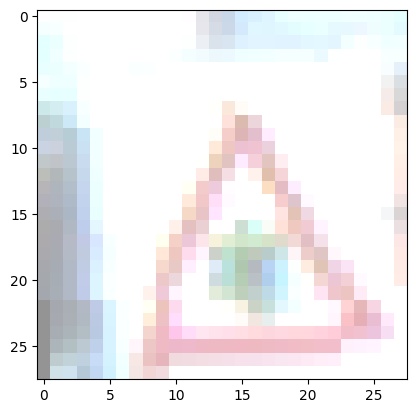

30 




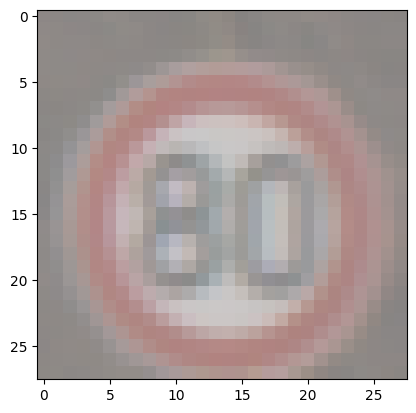

5 




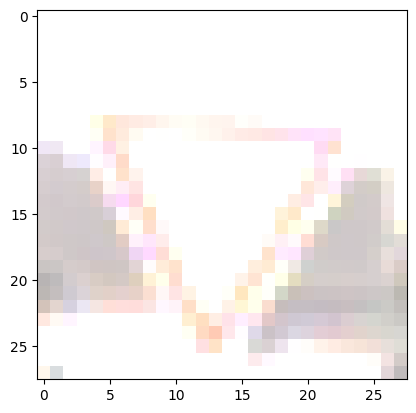

13 




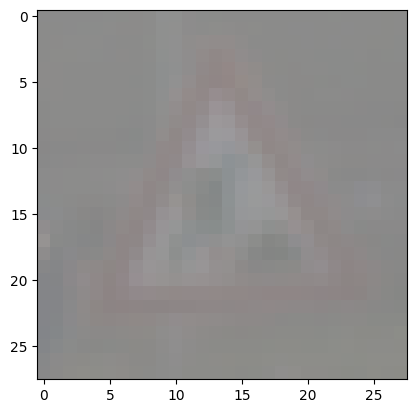

25 




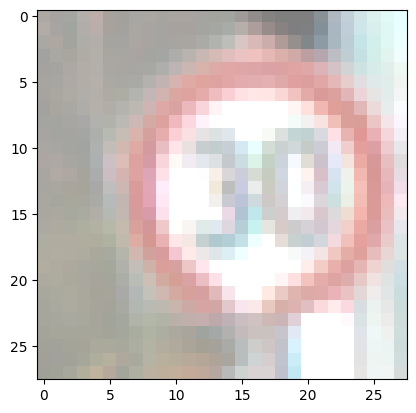

1 




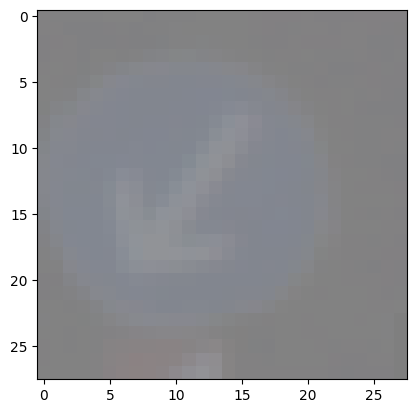

39 




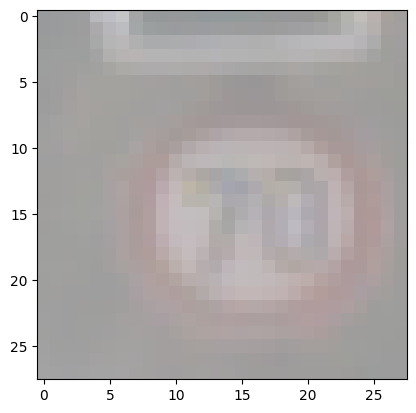

4 




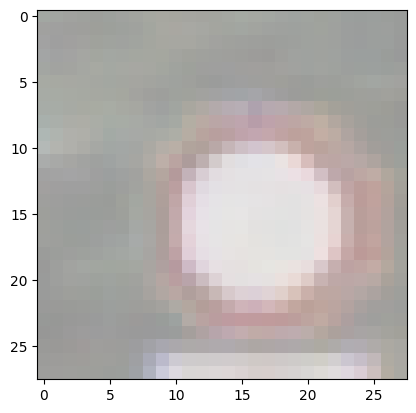

15 




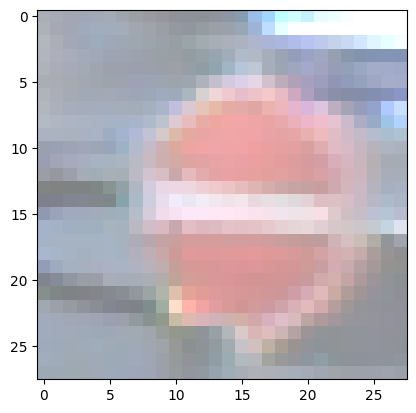

17 




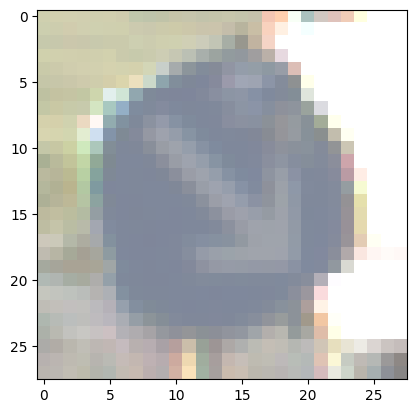

38 




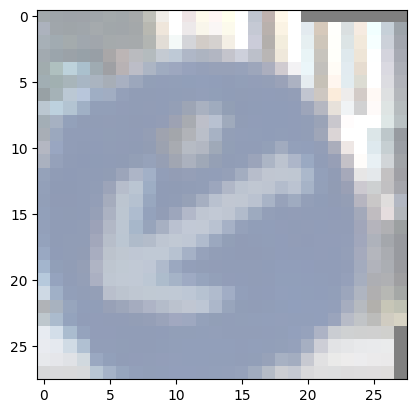

39 




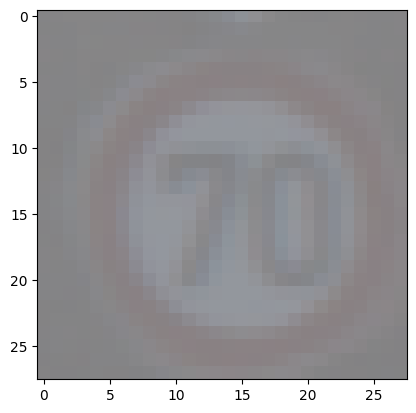

4 




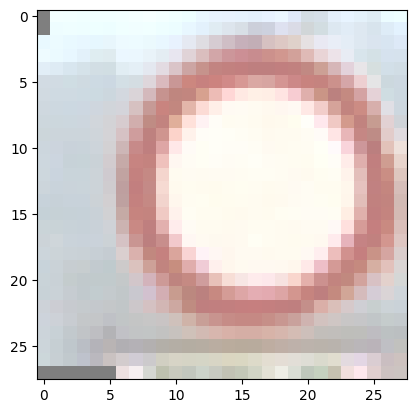

15 




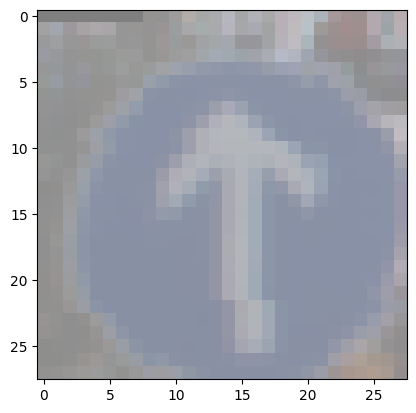

35 




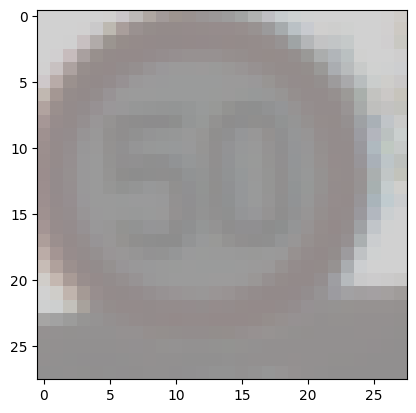

2 




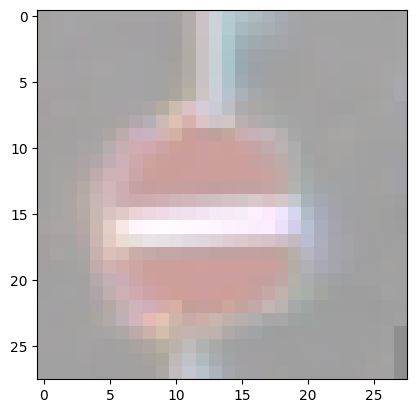

17 




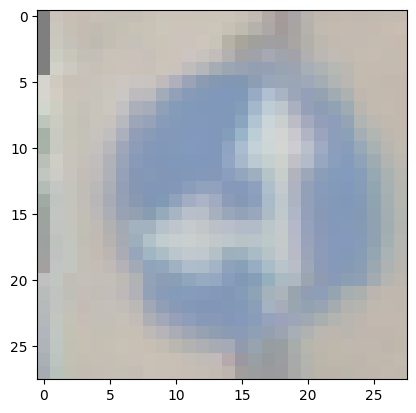

37 




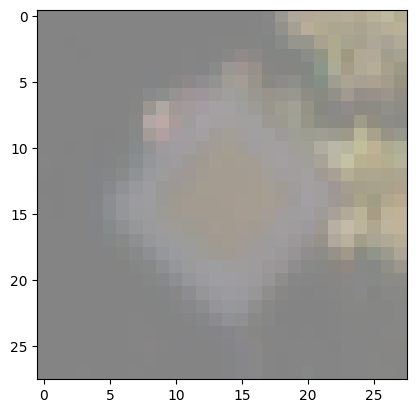

12 




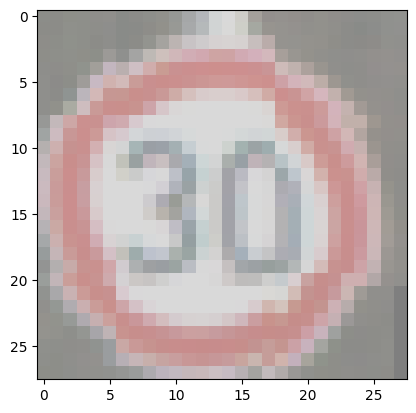

1 




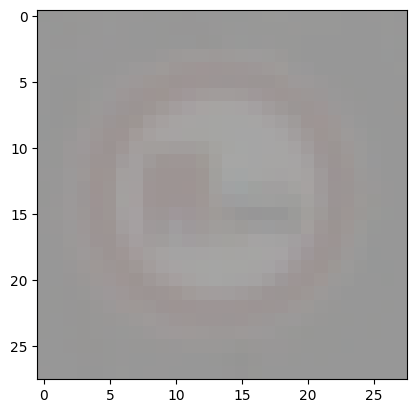

10 




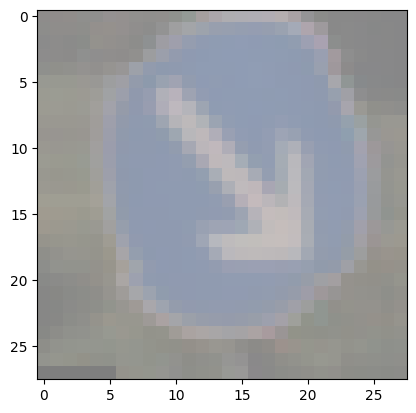

38 




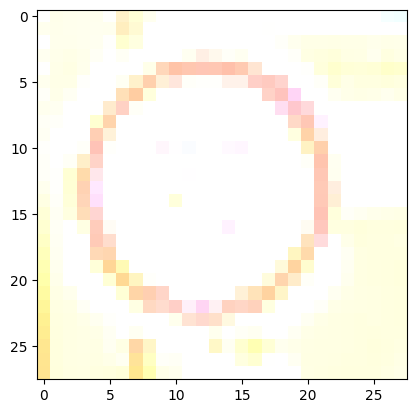

4 




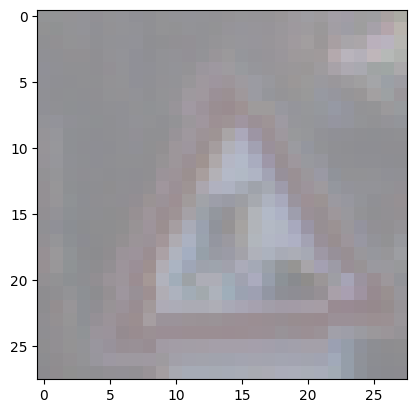

25 




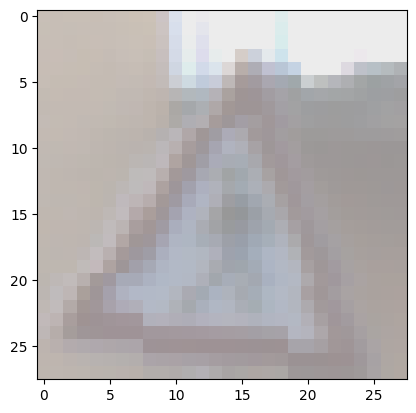

27 




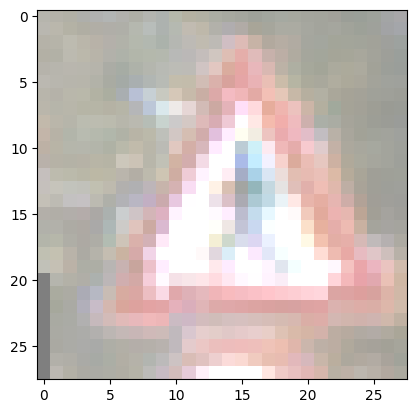

27 




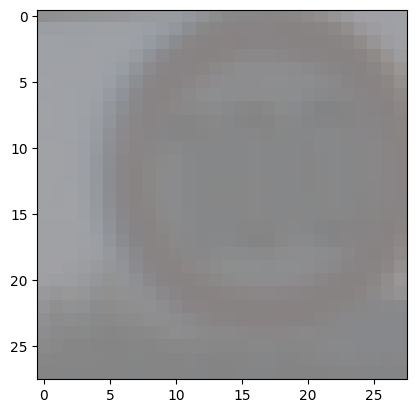

7 




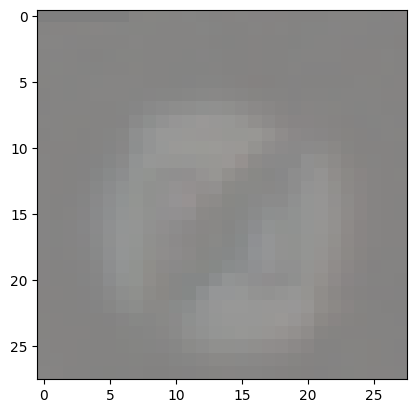

6 




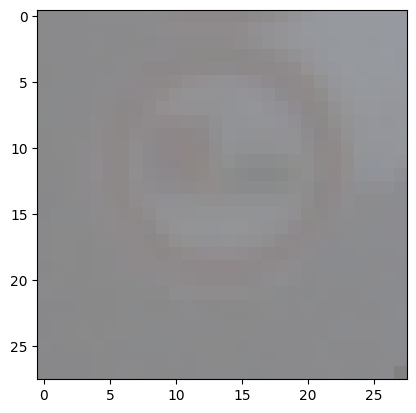

10 




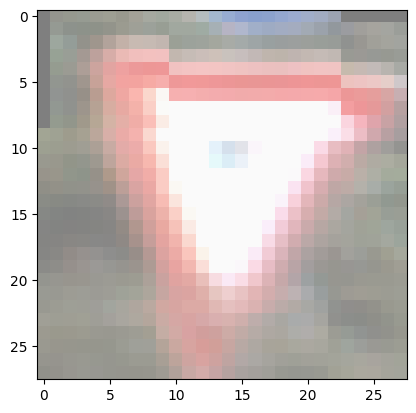

13 




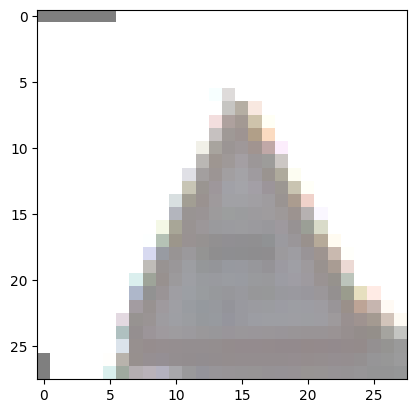

23 




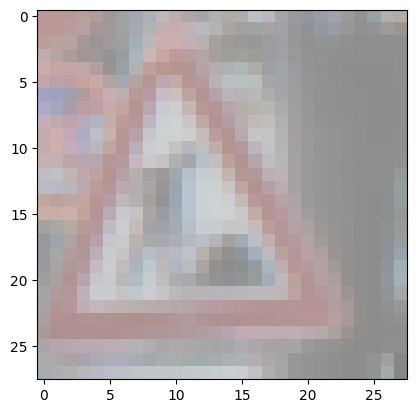

25 




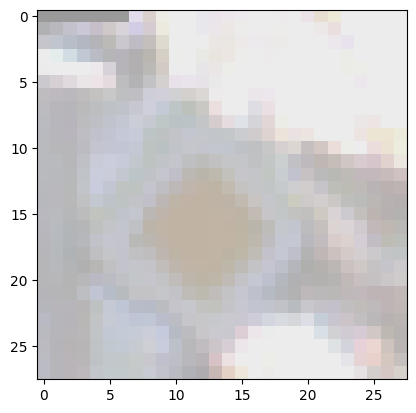

12 




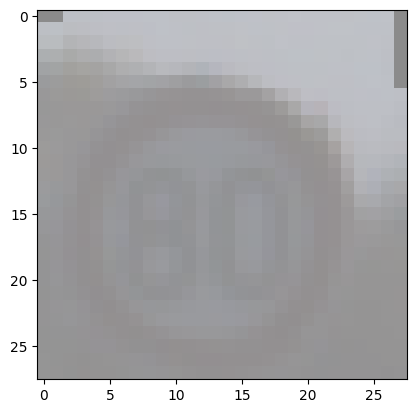

5 




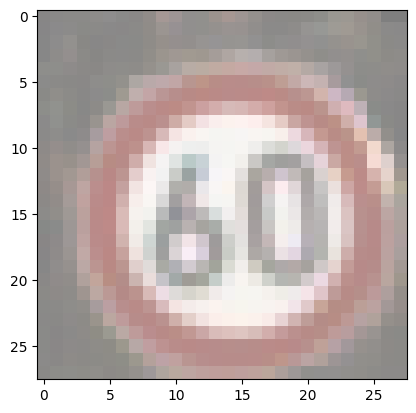

3 




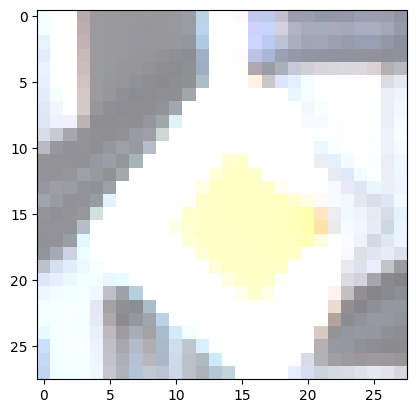

12 




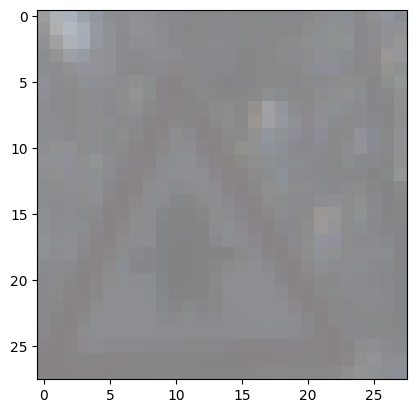

11 




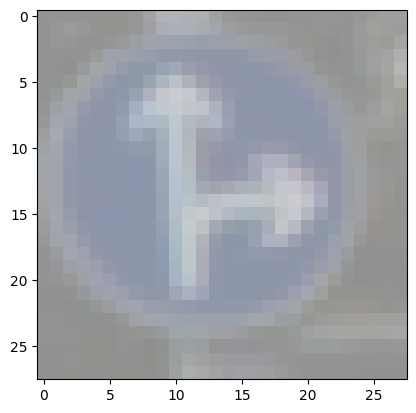

36 




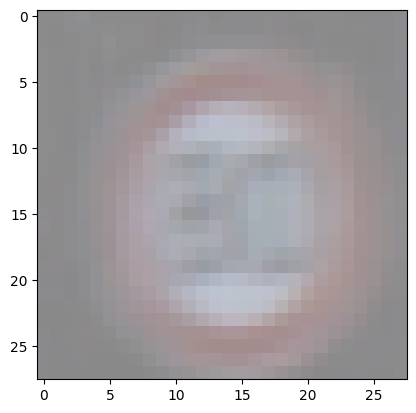

5 




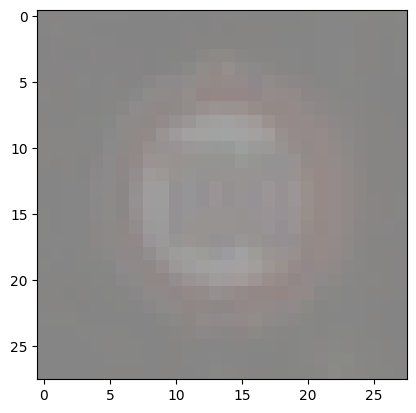

7 




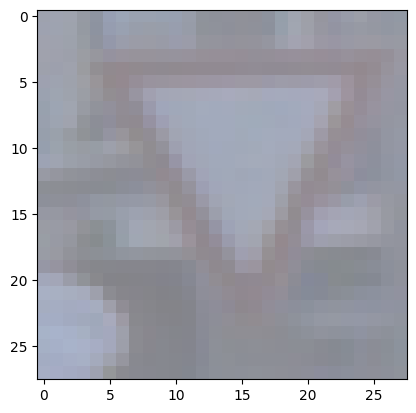

13 




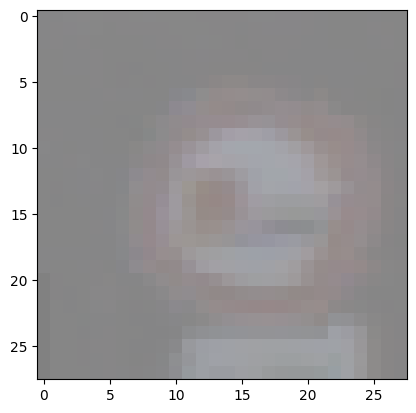

10 




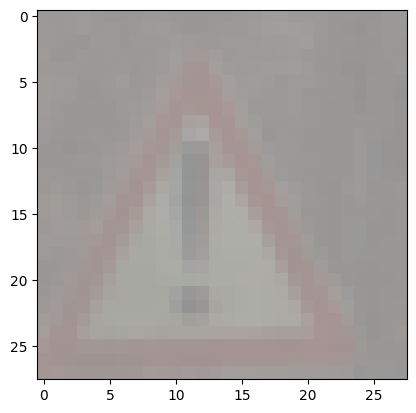

18 




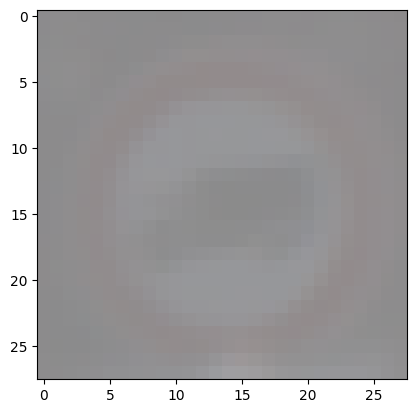

16 




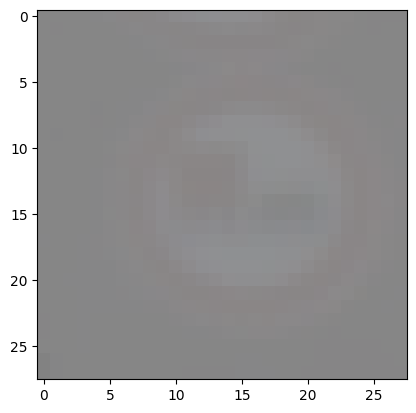

10 




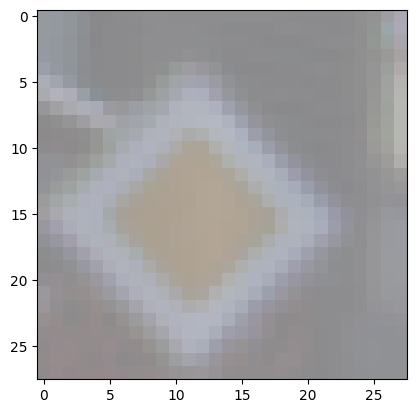

12 




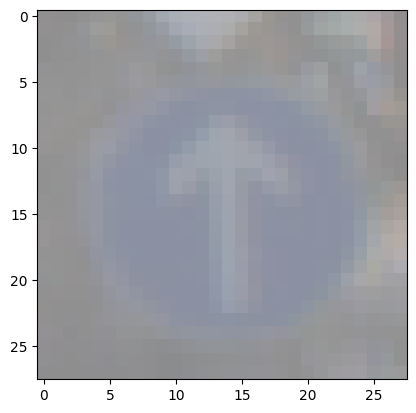

35 




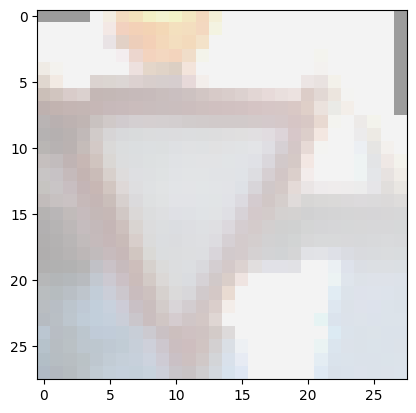

13 




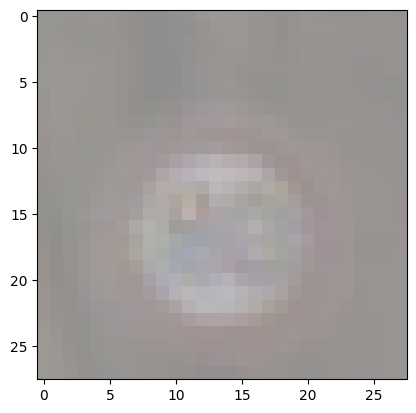

5 




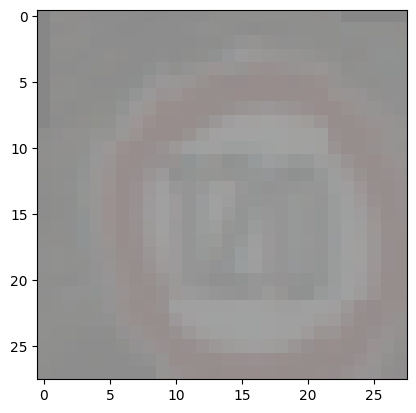

8 




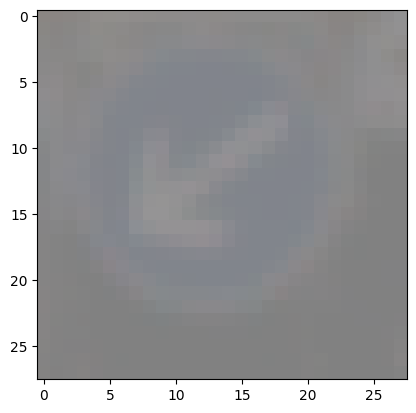

39 




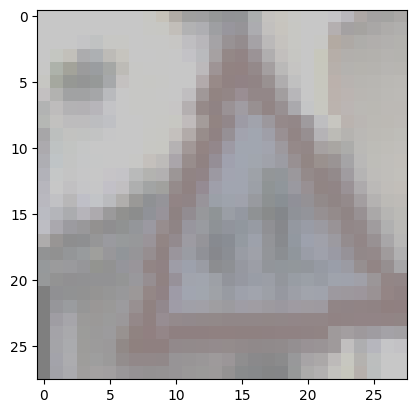

28 




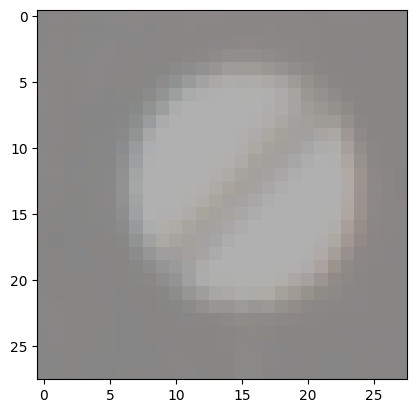

32 




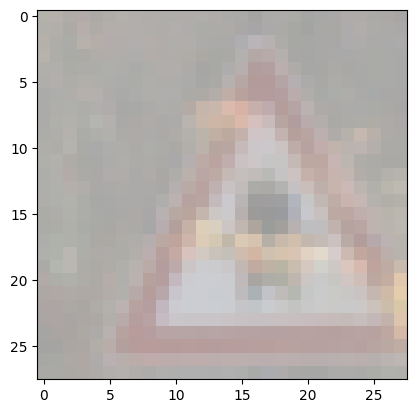

11 




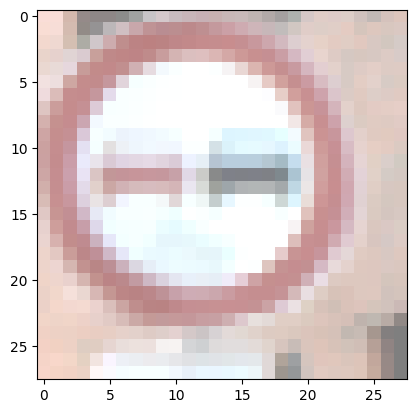

9 




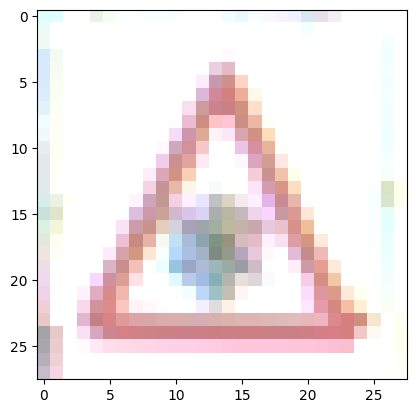

30 




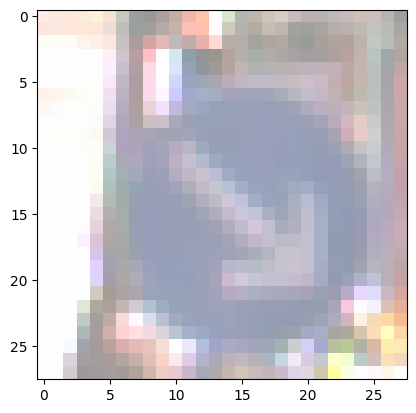

38 




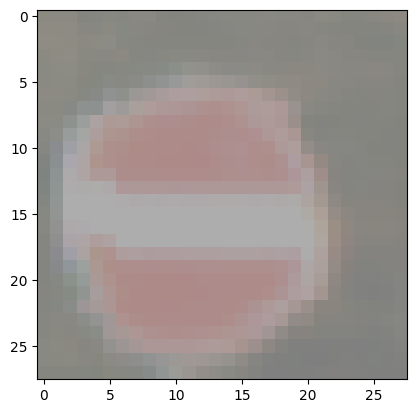

17 




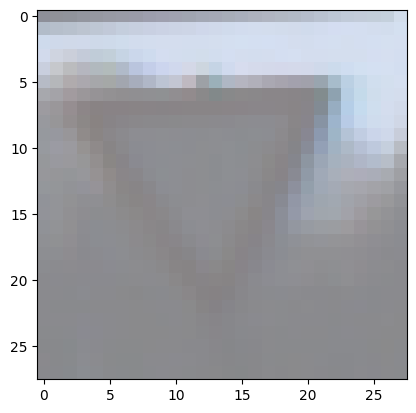

13 




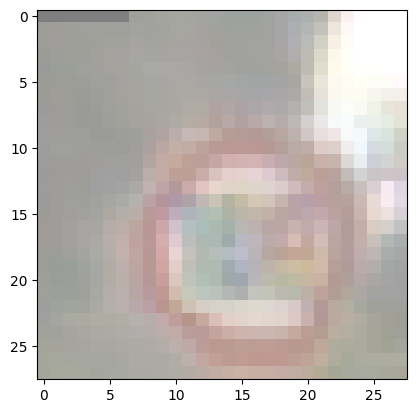

7 




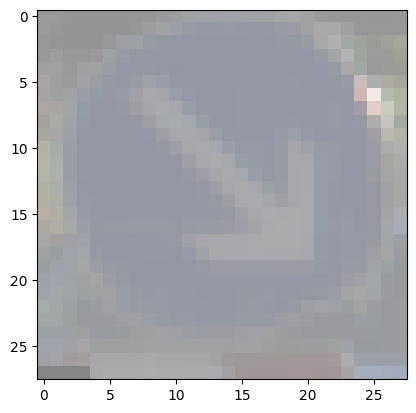

38 




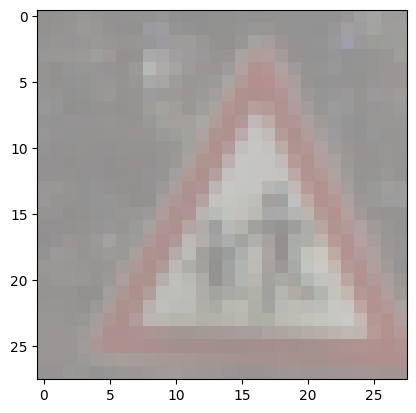

28 




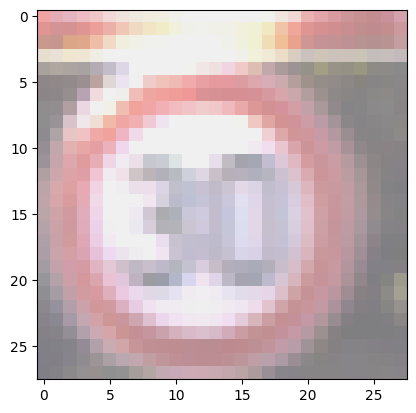

1 




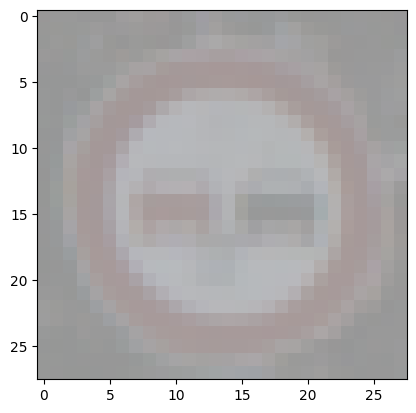

9 




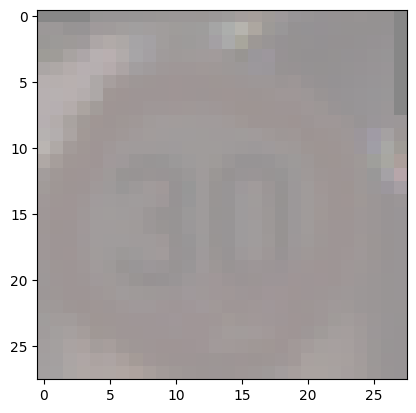

1 




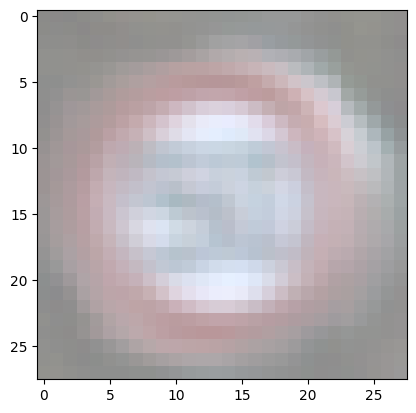

2 




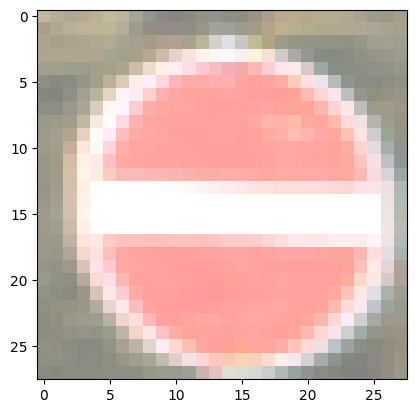

17 




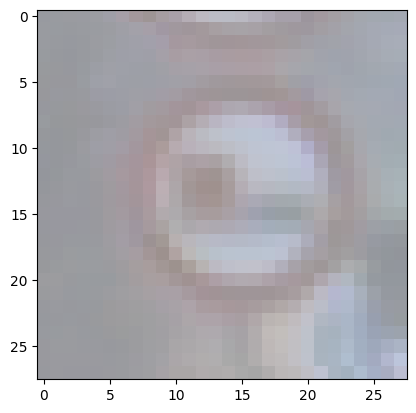

10 




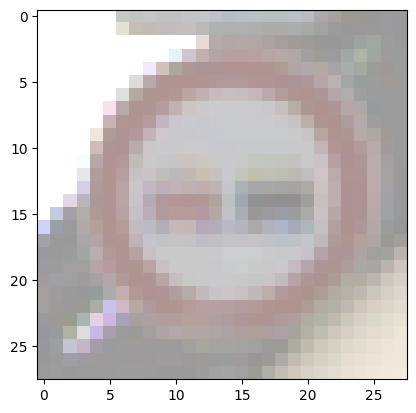

9 




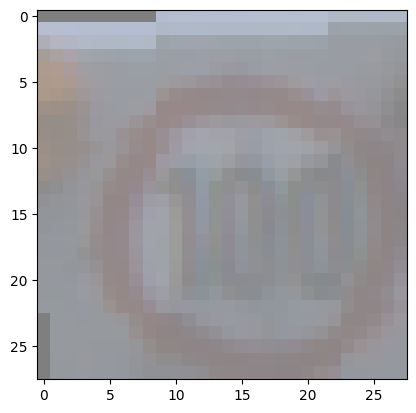

7 




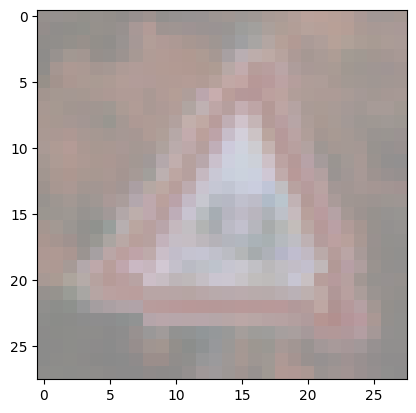

29 




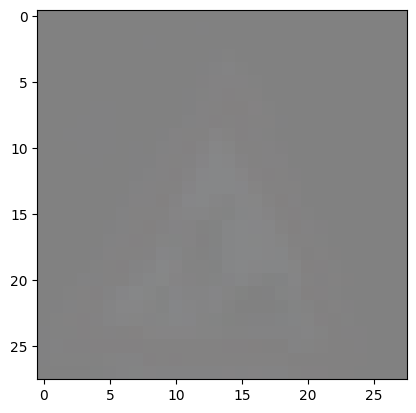

25 




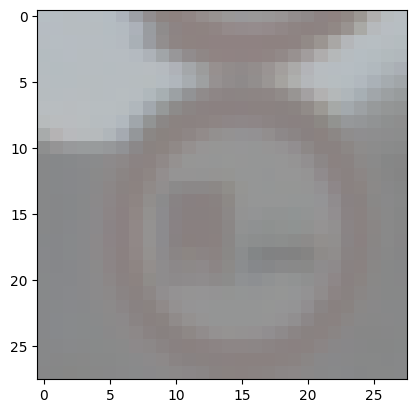

10 




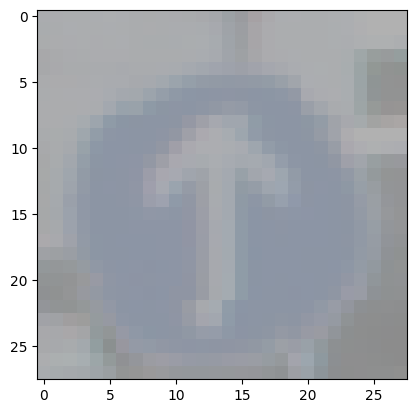

35 




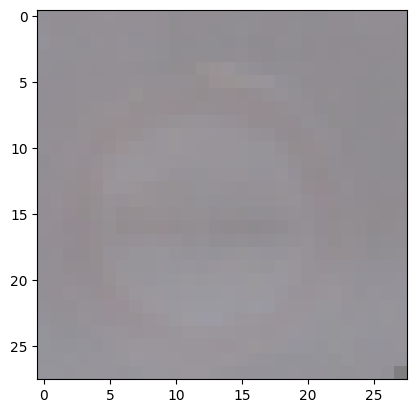

9 




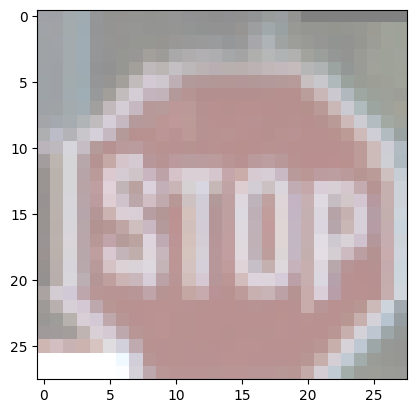

14 




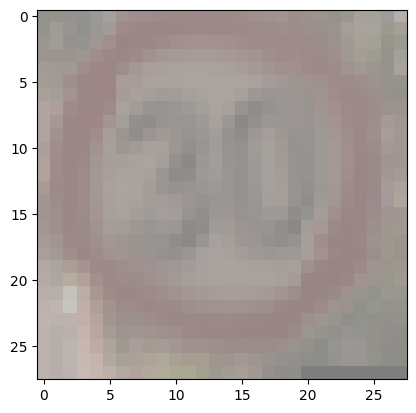

1 




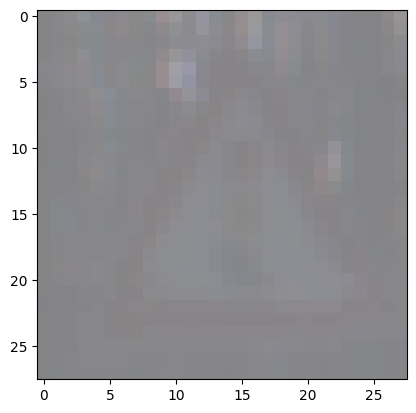

26 




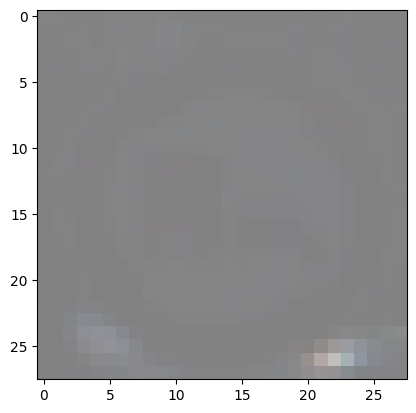

10 




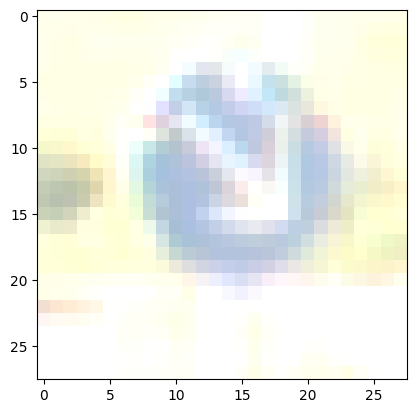

38 




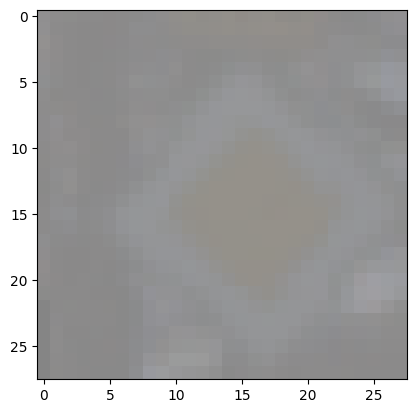

12 




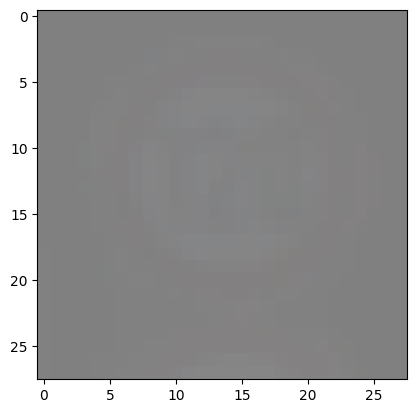

8 




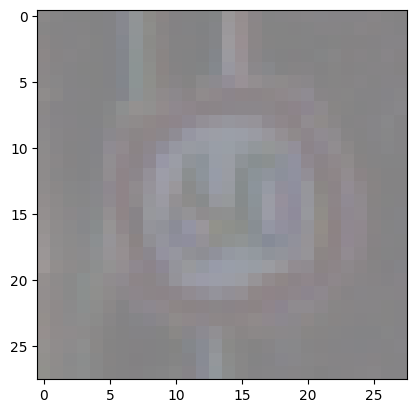

3 




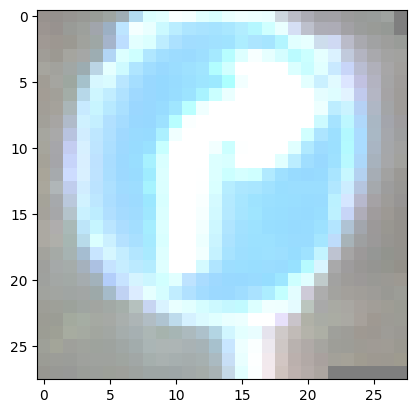

33 




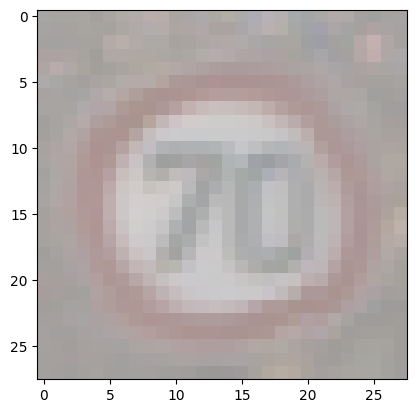

4 




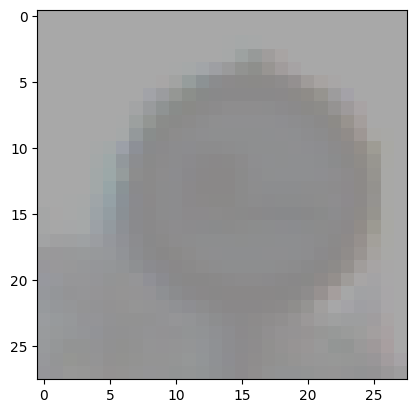

10 




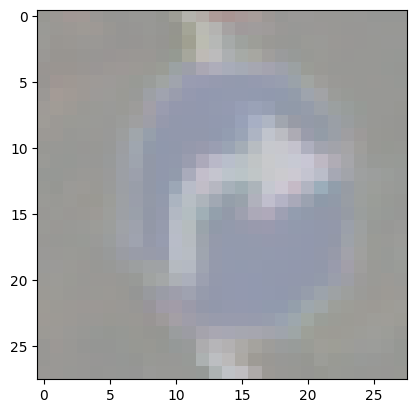

33 




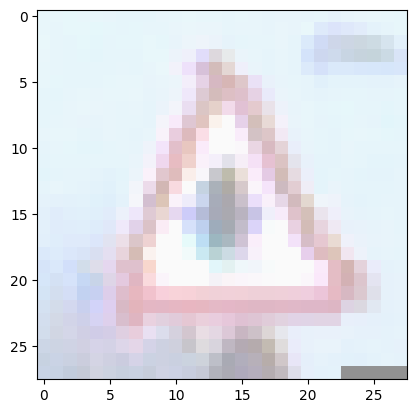

11 




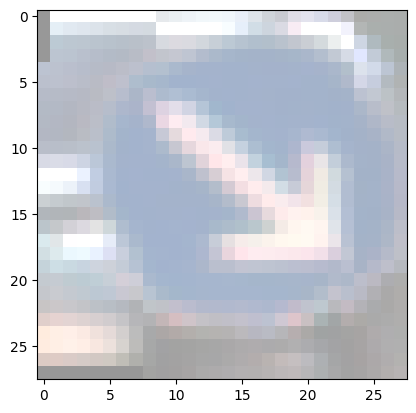

38 




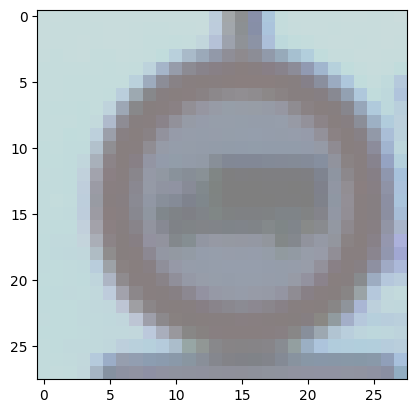

16 




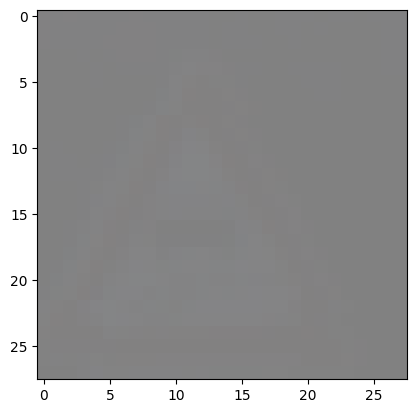

23 




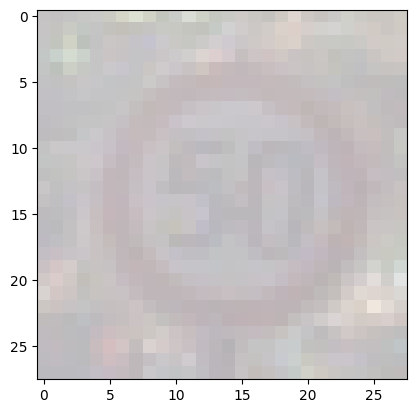

2 




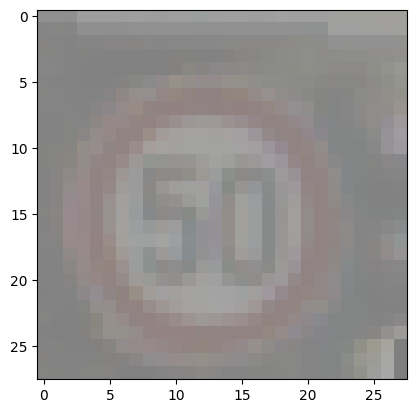

2 




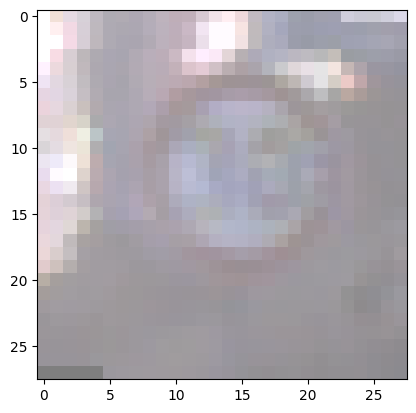

1 




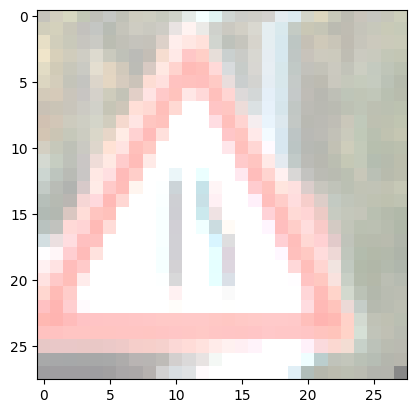

24 




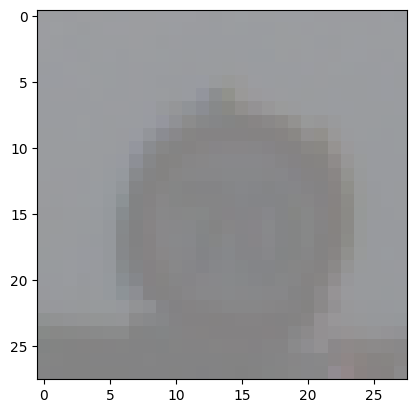

4 




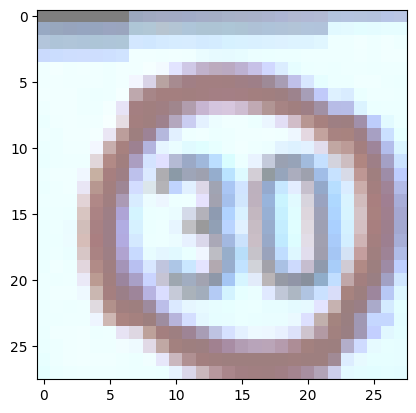

1 




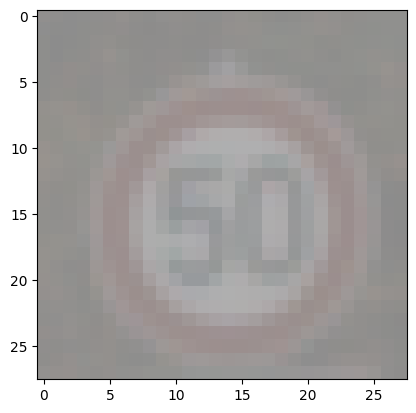

2 




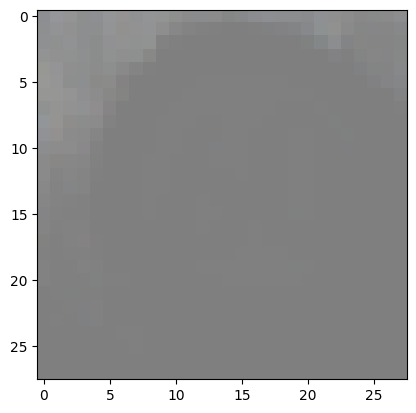

3 




In [9]:
for i in range(batch_size):
    imshow(images[i])
    print(labels[i].item(), "\n\n")


Define the neural network:

In [9]:
DEBUG = False
_print = lambda x: DEBUG and print(x)
class Net(nn.Module):
    def __init__(self, img_size = 28):
        super().__init__()

        self.conv1 = nn.Conv2d(3, 64, kernel_size = 5)
        self.elu1  = nn.ELU()
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(64, 64, kernel_size = 5)
        self.elu2  = nn.ELU()
        self.pool2 = nn.MaxPool2d(2)
        self.fc2   = nn.Linear(1024, 43)

    def forward(self, x):

        x = self.conv1(x)
        _print(f"after conv1: {x.shape}")

        #x = self.elu1(x)
        #_print(f"after elu1:  {x.shape}")

        x = self.pool1(x)
        _print(f"after pool1: {x.shape}")

        x = self.conv2(x)
        _print(f"after conv2: {x.shape}")

        #x = self.elu2(x)
        #_print(f"after elu2:  {x.shape}")

        x = self.pool2(x)
        _print(f"after pool2: {x.shape}")

        x = x.view(-1, 1024)
        _print(f"after view:  {x.shape}")

        x = self.fc2(x)
        _print(f"after fc2:   {x.shape}")
        global DEBUG
        DEBUG = False
        return x


Instantiate the neural network and potentially move it to GPU:

In [10]:
net = Net()
if(gpu):
    net.to(device)
print(net)

Net(
  (conv1): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1))
  (elu1): ELU(alpha=1.0)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1))
  (elu2): ELU(alpha=1.0)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc2): Linear(in_features=1024, out_features=43, bias=True)
)


Define loss and optimization algorithm:

In [11]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001, eps=0.1)

These lines can be used to continue training:

In [12]:
cont = False
if cont:
    net.load_state_dict(torch.load('traffic_simple'))

Do the training:

In [ ]:
no_epochs = 50
DEBUG = True

for epoch in range(no_epochs):  # Loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(generator_train, 0):
        # Get the inputs; data is a list of [inputs, labels]
        if (gpu):
            inputs, labels = data[0].to(device), data[1].to(device)
        else:
            inputs, labels = data
        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Print statistics
        reporting_interval = 100
        running_loss += loss.item()
        if i % reporting_interval == reporting_interval-1:  # Print every reporting_interval mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / reporting_interval))
            running_loss = 0.0

print('Finished Training')

after conv1: torch.Size([128, 64, 24, 24])
after pool1: torch.Size([128, 64, 12, 12])
after conv2: torch.Size([128, 64, 8, 8])
after pool2: torch.Size([128, 64, 4, 4])
after view:  torch.Size([128, 1024])
after fc2:   torch.Size([128, 43])
[1,   100] loss: 3.288
[1,   200] loss: 3.147
[1,   300] loss: 2.991
[2,   100] loss: 2.810
[2,   200] loss: 2.652
[2,   300] loss: 2.531
[3,   100] loss: 2.385
[3,   200] loss: 2.267
[3,   300] loss: 2.127


Evaluate on test set:

In [14]:
dataset_test = GTSRBTrafficSigns(train = False)
generator_test = torch.utils.data.DataLoader(dataset_test, batch_size=batch_size, shuffle=False, num_workers=4)
print("Number of test patterns:", len(dataset_test))

Using existing ./GTSRB/test
Number of test patterns: 12630


In [15]:
correct = 0
total = 0
with torch.no_grad():
    for data in generator_test:
        if (gpu):
            images, labels = data[0].to(device), data[1].to(device)
        else:
            images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on test images: %.2f %%' % (100 * correct / total))

Accuracy of the network on test images: 20.63 %


Save network:

In [64]:
torch.save(net.state_dict(), 'traffic_simple')